In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) #no scientific notation
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [4]:
df = pd.read_csv(r"Geo Modified Dataset - 80 cells - width==0.1 .csv", index_col=(0,1))

race_set = set(['ASIAN', 'BLACK', 'HISPANIC', 'NATIVE AMERICAN', 'OTHER', 'WHITE'])
race_set_w_out_NA = set(['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE'])

# Define Necessary Functions

## Create a dataframe of raw stop count

e.g. raw_count_df['ASIAN'][10] = $\#\, asian \, stops\, at\, 10\, mph\,$

In [5]:
def generate_raw_count_df(dataframe, a, b):
    count_between_a_b_mph_intermediate_dict = {race:{x:0 for x in list(range(a, b+1))} for race in race_set}
    race_total_between_a_b_mph = {race:0 for race in race_set}

    #raw count of speeds 
    for x in list(zip(dataframe['Speed Over Posted Limit'], dataframe['Race'])):
        if a <= x[0] <= b:
            count_between_a_b_mph_intermediate_dict[x[1]][x[0]] += 1
            race_total_between_a_b_mph[x[1]] += 1
            
    return pd.DataFrame(count_between_a_b_mph_intermediate_dict)

## Create a dataframe of percentage stop count

e.g. pct_stop_df['ASIAN'][10] = $\frac{asian \, stops\, at\, 10\, mph\,}{\,all\, asian\, stops}$

In [6]:
def create_speed_pct_PDF(dataframe, a, b):
    """       
    a = min speed
    b = max speed
    
    returns pd dataframe of all races' speeds percentages at a certain speed
    
    note: the range is inclusive
    """
    count_between_a_b_mph_intermediate_dict = generate_raw_count_df(df, a, b)
    
    race_total_between_a_b_mph = {race: count_between_a_b_mph_intermediate_dict[race].sum() for race in race_set}
    
    percent_between_a_b_mph_df = pd.DataFrame({race: 100 * count_between_a_b_mph_intermediate_dict[race]/count_between_a_b_mph_intermediate_dict[race].sum() for race in race_set})
    
    return percent_between_a_b_mph_df

## ~~Return % leq a specific speed ~~(No longer needed)

In [7]:
def pct_leq_n_mph(speeding_percentages_list, n):
    
    """
    INCLUSIVE range
    
    n = specific speed
    """
    
    return sum([mph for i, mph in enumerate(speeding_percentages_list) if i <= n]) / sum([mph for mph in speeding_percentages_list]) #make it "i+a" if want a range starting at "a"

## Returns a dataframe with df[race][x] = % $\leq $ speed *x*

In [11]:
def generate_pct_CDF(speeding_percentages_df):
    
    return speeding_percentages_df.cumsum()

## Returns a dataframe with df[race][x] = number of observations $\leq$ x

In [12]:
raw_count_df = generate_raw_count_df(df, 0, 100)
raw_count_cumulative_df = raw_count_df.cumsum()

In [13]:
speed_pct_PDF = create_speed_pct_PDF(df, 0, 100)
speed_pct_CDF = generate_pct_CDF(speed_pct_PDF)

## Plot Quantiles to check equality

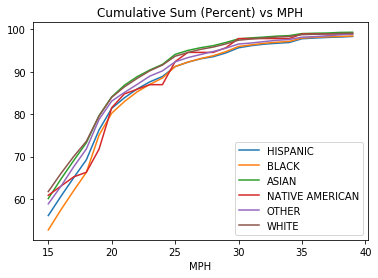

In [30]:
speed_pct_CDF[15:40].plot(title='Cumulative Sum (Percent) vs MPH')

### Check Quantiles for Equality

In [29]:
speed_pct_CDF.index.name = 'MPH'
speed_pct_CDF.iloc[[x for x in range(10,50) if x % 5 == 0 and x % 10 != 0]]

,HISPANIC,BLACK,ASIAN,NATIVE AMERICAN,OTHER,WHITE
MPH,,,,,,
15,56.099528,52.716188,60.104195,60.869565,58.861314,61.758360
25,91.226111,91.216557,94.091034,92.391304,92.335766,93.660277
35,97.778605,97.930338,98.999177,98.913043,98.145985,98.744917
45,99.280218,99.355415,99.684672,98.913043,99.562044,99.630736


## Adds columns of differences between columns

In [94]:
def create_difference_between_races(speed_CDF):
    already_done = []

    for race in race_set_w_out_NA:
        for race2 in race_set_w_out_NA:
            if race != race2:
                if sorted([race, race2]) not in already_done:
                    
                    speed_CDF[f"{race} - {race2}"] = abs(speed_CDF[race] - speed_CDF[race2])
                    
                    already_done.append(sorted([race, race2]))


In [95]:
create_difference_between_races(speed_pct_CDF)

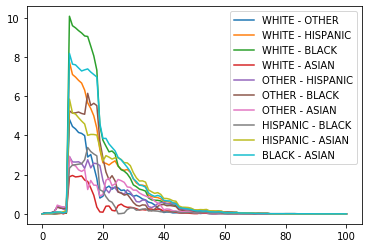

In [165]:
speed_pct_CDF[speed_pct_CDF.columns[6:]].plot()

# Z-test for different distributions/means

## Function for z_test

In [178]:
def z_statistic(race1, race2, speed): #meant to be applied to speed_pct_CDF
    
    p1 = speed_pct_CDF[race1][speed]/100
    p2 = speed_pct_CDF[race2][speed]/100
    
    n1 = raw_count_cumulative_df[race1][speed]
    n2 = raw_count_cumulative_df[race2][speed]
    
    numerator = p1 - p2
    
    denominator = np.sqrt( (p1 * (1-p1))/n1 + (p2 * (1-p2))/n2 )
    
    return numerator / denominator

In [179]:
def create_z_stat_df():
    
    local_z_stat_df = pd.DataFrame()

    already_done = []

    for race in race_set_w_out_NA:
        for race2 in race_set_w_out_NA:
            if race != race2:
                if sorted([race, race2]) not in already_done:

                    local_z_stat_df[f"{race} - {race2}"] = [z_statistic(race, race2, n) for n in range(0,101)]

                    already_done.append(sorted([race, race2]))

    return local_z_stat_df


In [180]:
z_stat_df = create_z_stat_df()
z_stat_df['95% CI UPPER'] = 1.96
z_stat_df['95% CI LOWER'] = -1.96

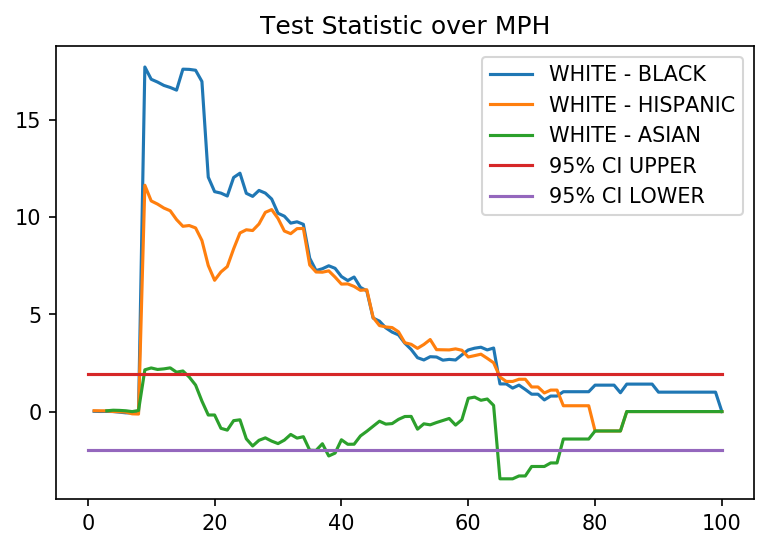

In [197]:
mpl.rcParams['figure.dpi']= 150
z_stat_df[['WHITE - BLACK', 'WHITE - HISPANIC', 'WHITE - ASIAN', '95% CI UPPER', '95% CI LOWER']].plot(title='Test Statistic over MPH')

# Conclusion

(White, Black); and (White, Hispanic) appear to have different distributions